In [1]:
import h5py 
import scipy 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from scipy import stats
import os
import spts
import spts.camera
from spts.camera import CXDReader
import pandas as pd
import sys

In [ ]:
def make_circle_mask(diameter):
    center = (diameter-1.) / 2.
    x,y = np.meshgrid(np.arange(diameter), np.arange(diameter))
    rsq = (x-center)**2 + (y-center)**2
    mask = rsq <= center**2
    return mask

def combine_datafiles(filelist): 
    '''
    input:
    filelist - list of directory and filenames of the analysed and to be combined spts.cxi files
    
    output:
    [0]: hits_correctedall - array with length len(filelist)
    [1]: hitxall - array with length len(found particles)
    [2]: hityall - array with length len(found particles)
    [3]: hits_correctedall_single - array with length len(found particles)
    [4]: hitframeall - array with length len(found particles)
    - opens spts.cxi file
    - ignores hits with intensity < 0
    - NO FURTHER REMOVAL OF PARTICLES DONE HERE
    '''
    
    n_data = len(filelist)
    hits_corrected = []
    hits_correctedall = []
    hits_correctedall_single = []
    hitxall = []
    hityall = []
    hitframeall = []
    
    for i in range(n_data):
            
        f_name = filelist[i]
        print(i+1, '/',n_data, f_name)

        hits = 0  
        frames = 0 
        hit_intensity = 0 
        hit_intensities = np.empty(shape = (0)) 
        hit_x = np.empty(shape = (0)) # array for storing x-location of hit 
        hit_y = np.empty(shape = (0)) # array for storing y-location of hit 
        hit_frame = np.empty(shape = (0), dtype = int) # array for storing frame number of hits 

        f = h5py.File(f_name, 'r')

        frames += f['/5_detect/n'].shape[0] 
        hits += np.sum(f['/5_detect/n'])
        hits_per_frame = np.array(f["/5_detect/n"])

        #print('Number of frames:', frames) 
        #print('Number of raw hits:', hits) 

        for i in range(0, f['/5_detect/x'].shape[0]): # frame counter 
            for j in range(0, f['/5_detect/n'][i]): # particle counter 
                if f['/6_analyse/peak_sum'][i, j] > 0: # ignore hits with intensity lower than zero 
                    hit_x = np.append(hit_x, f['/5_detect/x'][i, j]) 
                    hit_y = np.append(hit_y, f['/5_detect/y'][i, j]) 
                    hit_frame = np.append(hit_frame, i)
                           
        a = np.array(f['/6_analyse/peak_sum']) 
        real_hits = np.sum((a > 0)) 
        #print('Number of real hits (intensity > 0):', real_hits) 
        #print()
        hit_intensities = np.append(hit_intensities, a[a > 0]) 

        sat_pix = np.array(f["/1_raw/saturated_n_pixels"])
        success_pix = np.array(f["/1_raw/success"])

        num_saturated_pixels = np.sum(sat_pix[sat_pix != 0])

        num_saturated_frames = np.sum(success_pix == 0)
        num_nonsaturated_frames = np.sum(success_pix == 1)

        fraction_saturated = num_saturated_frames / num_nonsaturated_frames

        #print("Number of saturated pixels: %s" % (num_saturated_pixels))
        print("Number of saturated frames: %s/%s" % (num_saturated_frames, frames))
        #print("Number of non-saturated frames: %s/%s" % (num_nonsaturated_frames,frames))
        #print("Percentage of saturated frames: %.4s%%" % (fraction_saturated*100))

        av_intensity = np.mean(hit_intensities) 
        med_intensity = np.median(hit_intensities) 
        std_intensity = np.std(hit_intensities) 
        min_intensity = np.min(hit_intensities) 
        max_intensity = np.max(hit_intensities) 
        mad_intensity = scipy.stats.median_abs_deviation(hit_intensities)

        hits_corrected, hitx, hity, hitframe = [], [], [], []
        hits_remain, hits_del = 0, 0
        for h in range(len(hit_intensities)): 
            hit_h = hit_intensities[h] 
            hx, hy, hf = hit_x[h], hit_y[h], hit_frame[h]
            if hit_h >= 0 : 
                hitx.append(hx) 
                hity.append(hy) 
                hitframe.append(hf)
                hits_corrected.append(hit_h) 
                hits_remain += 1
            else:
                hits_del += 1

        hits_corrected = np.array(hits_corrected)
        hitx = np.array(hitx) 
        hity = np.array(hity) 
        hitframe = np.array(hitframe)
            
        hits_correctedall = np.append(hits_correctedall, np.median(hits_corrected**(1/6))) # appends median sixths root intensity
        hits_correctedall_single = np.append(hits_correctedall_single, hits_corrected**(1/6)) # appends all sixths root hit intensities
        hitxall = np.append(hitxall, hitx) # all hit x-positions
        hityall = np.append(hityall, hity) # all hit y-positions
        hitframeall = np.append(hitframeall, hitframe) # all hit frame numbers
        
    return hits_correctedall, hitxall, hityall, hits_correctedall_single, hitframeall

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def plot_DMA(filename, datanumber):
    with open(filename, "rb") as f:
        list1 = []
        for line in f:
            list1 = np.append(list1, line)
            #print(line)

    #load all lines including actual data into list2. Neglecting all supporting 
    #        information from the txt file. 
    list2 = []
    for i in range(21, np.shape(list1)[0]-27):   
        list2 = np.append(list2, list1[i].astype(str))

    #generating a 2D array from list2
    arr=list2
    sample = np.zeros((len(arr),len(arr[0].split("\t")) ))
    for i in range(len(arr)):
        #print(arr[i])
        sample[i] = arr[i].split("\t")

    diameter = sample[:,0]
    s = datanumber
    
    return diameter, sample[:,s]

def linear(x, a):
    return a*x

def linear_b(x, a, b):
    return a*x + b

def files_from_folder(folderpath, log_path, exclude = []):
    #create list of files ending with "cxi" in folderpath
    files = [f for f in os.listdir(folderpath) if f.endswith('.cxi')]
    
    files = [f for f in files if f not in exclude]

    try:
        log = pd.read_csv(log_path)
    except Exception as e:
        print(f"Could not find log file at path: {log_path}. {e}")
        sys.exit(1)

    # Function to change the ending of the values
    def change_ending(value, old_ending, new_ending):
        if pd.notna(value) and value.endswith(old_ending):
            return value[:-len(old_ending)] + new_ending
        return value
    
    # Apply the function to specific columns
    log['File'] = log['File'].apply(change_ending, args=('.cdx', '.cxd'))

    files_dict = {}
    for file in files:
        row = log.loc[log['File'].str[:-4] == file[:9]]
        description = row['Description'].values[0]
        if description in files_dict:
            files_dict[description].append(folderpath + file)
        else:
            files_dict[description] = [folderpath + file]

    #sort dictionary by key alphabetically
    files_dict = dict(sorted(files_dict.items()))

    return files_dict

def combine_lists(files):
    particles_list = []
    for key in files:
        particles_list.append(combine_datafiles(files[key]))

    return particles_list

def filter4keys(files, keys):
    #filter the files dictionory if for when its key is contained in keys
    filtered_files = {}
    #enumerate over files dictionary
    for file_key in files.keys():
        #if the key from keys is contained in the file_key then add the file to the new dictionary
        for key in keys:
            #check if the string key is contained in the file_key
            if key in file_key:
                filtered_files[file_key] = files[file_key]

    return filtered_files

In [ ]:
files_w05 = files_from_folder(   "/home/rwendl/data/ps_raffi/spts_ps_raffi_w05/",
                                                "/home/rwendl/data/consts/scatter_log.csv")

files_w25 = files_from_folder(   "/home/rwendl/data/ps_raffi/spts_ps_raffi_w25/",
                                                "/home/rwendl/data/consts/scatter_log.csv")

#print(files_w05)
#print(files_w25)

#files_w05 = filter4keys(files_w05, ["20", "30", "40"]) #filter for 20, 30, 40nm particles

particles_w05 = combine_lists(files_w05)
particles_w25 = combine_lists(files_w25)


1 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00126_ana_w05.cxi
Number of saturated frames: 0/2000
2 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00122_ana_w05.cxi
Number of saturated frames: 0/2000
3 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00117_ana_w05.cxi
Number of saturated frames: 0/2000
4 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00119_ana_w05.cxi
Number of saturated frames: 1/2000
5 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00121_ana_w05.cxi
Number of saturated frames: 0/2000
6 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00128_ana_w05.cxi
Number of saturated frames: 0/2000
7 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00135_ana_w05.cxi
Number of saturated frames: 0/2000
8 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00115_ana_w05.cxi
Number of saturated frames: 0/2000
9 / 20 /home/rwendl/data/ps_raffi/spts_ps_raffi_w05/data00133_ana_w05.cxi
Number of saturated frames: 1/2000
10 / 20 /home/rwend

/home/rwendl/.conda/envs/spts_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rwendl/.conda/envs/spts_new/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rwendl/.conda/envs/spts_new/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rwendl/.conda/envs/spts_new/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rwendl/.conda/envs/spts_new/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

[(array([4.09775274, 4.1002014 , 4.08916957, 4.12145029]), array([275.44444444, 170.21192053, 220.        , ..., 251.        ,
       180.79411765, 162.92592593]), array([434.40740741, 387.94701987, 430.8       , ..., 353.79310345,
        44.08823529,  97.7962963 ]), array([3.64214341, 5.29910545, 3.64029678, ..., 3.85411017, 3.87388868,
       4.37669758]), array([  1.,   2.,   2., ..., 997., 998., 998.])), (array([4.55291407, 4.62499409, 4.40053646, 4.58169517]), array([254.5       , 223.10416667, 303.14917127, ..., 290.9516129 ,
       205.28571429, 244.29577465]), array([225.71428571, 400.04166667, 374.60220994, ..., 449.82258065,
       476.5       , 297.32394366]), array([3.64367124, 4.11642468, 5.00086053, ..., 4.36553863, 3.68660049,
       4.08192213]), array([  0.,   0.,   1., ..., 993., 997., 999.])), (array([4.8228672 , 4.72599663, 4.72637359, 4.88672945]), array([247.00363636, 266.5       , 274.48979592, ..., 246.51991614,
       207.72033898, 260.02424242]), array([337.0

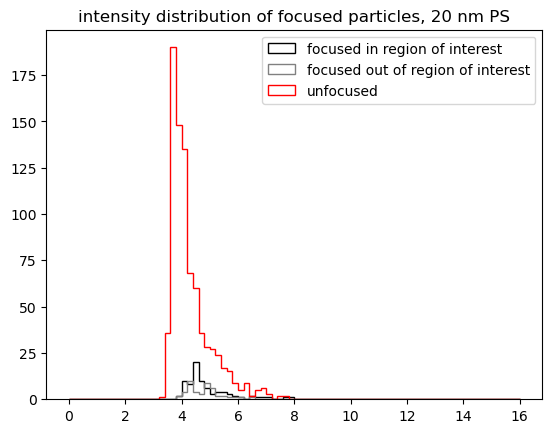

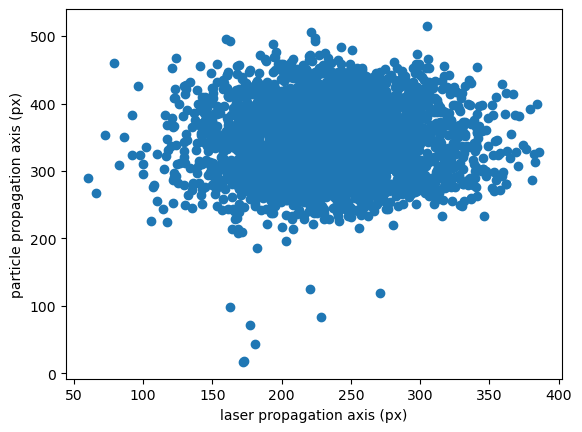

peak intensity of focused particles:  4.5
median position: 4.598565981871343
--------------------
2247 2249


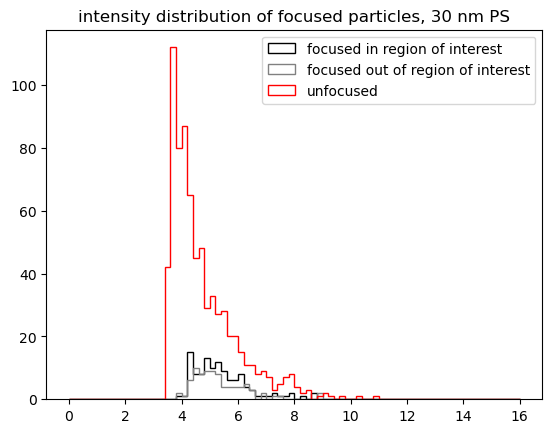

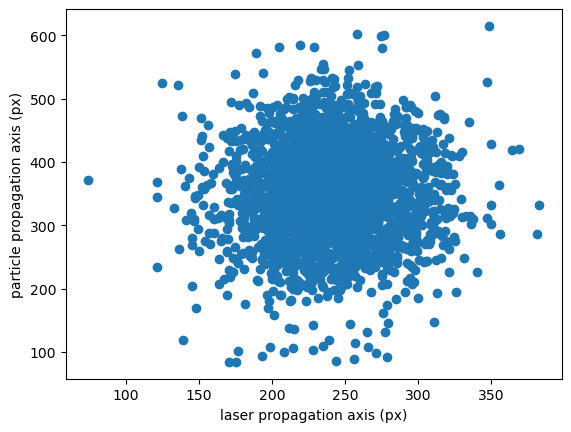

peak intensity of focused particles:  4.3
median position: 5.245207965705534
--------------------
1777 1778


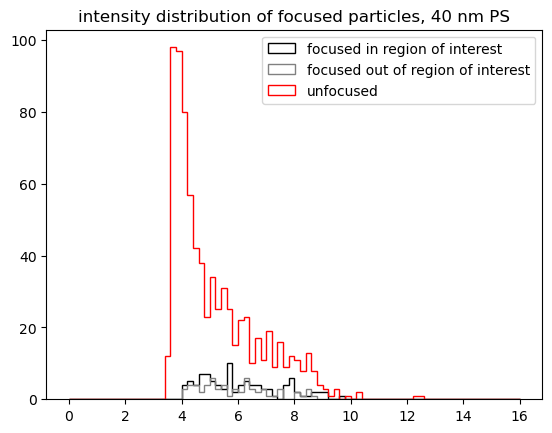

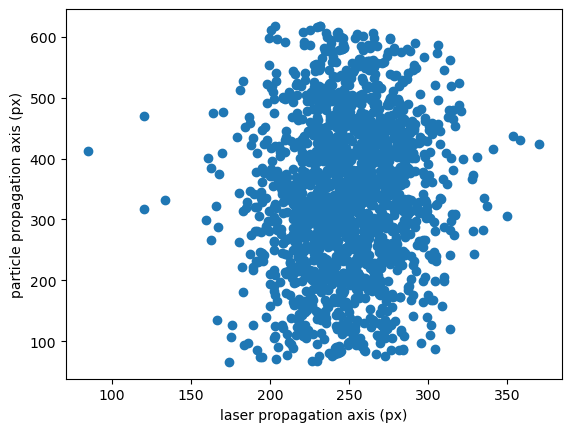

peak intensity of focused particles:  5.7
median position: 5.768713289798923
--------------------
2585 2590


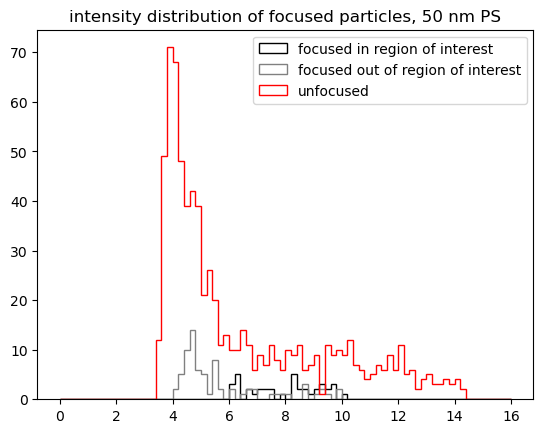

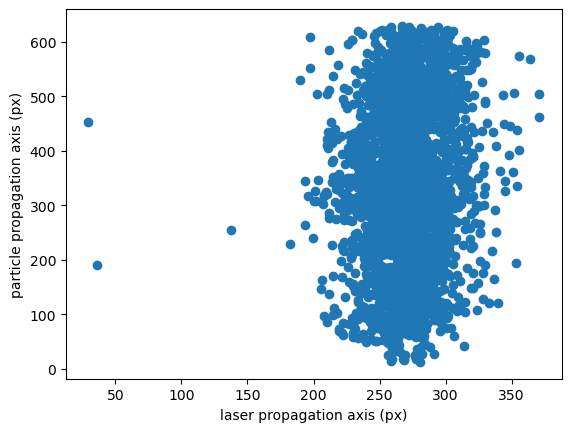

peak intensity of focused particles:  [6.2 8.2 9.3]
median position: 8.261888276890204
--------------------


In [ ]:
particles = particles_w25       #particles with windows size 25
particles2 = particles_w05      #particles with windows size 5

intensity_median = []
intensity_mean = []
intensity_std = []
intensity_mad = []

smps = 6                        #number of samples  (obsolete)
limup =     [0,0,0,0,0,0]       #set limit up for each sample, leave 0 for default
limdown =   [0,0,0,0,0,0]       #set limit down for each sample, leave 0 for default

Limit = 0.9                     #Intensity limit for focused particles

for m in range(len(particles)):

    sample = particles[m]
    sample2 = particles2[m]
    focused = []
    focused_out = []
    unfocused = []
    discard = []

    Limitup = 450
    Limitdown = 250

    if limup[m] != 0:
        Limitup = limup[m]
    if limdown[m] != 0:
        Limitdown = limdown[m]

    print(len(sample[4]), len(sample2[4]))
    for i in range(len(sample[4])-1):           #loop over all particles in sample
        if sample[4][i] == sample2[4][i]:           #if the frame number of the two samples is the same
            if sample[1][i] == sample2[1][i]:           #if the x-position of the two samples is the same
                #print(PS50[3][i], PS502[3][i])
                if sample[3][i] >= sample2[3][i] >= Limit*sample[3][i]:  #if the intensity of the small circle is larger than the large circle
                 #   print("focused")
                    if (sample[2][i]<Limitup)&(sample[2][i]>Limitdown):  #if the y-position is in the region of interest
                        #if m<3:
                        focused = np.append(focused, sample[3][i])
                        #if m==3:
                        #    if sample[3][i]>8:
                        #        focused = np.append(focused, sample[3][i])
                        #    else:
                        #        print('removed particle')
                    else:
                        focused_out = np.append(focused_out, sample[3][i])

                else:
                   # print("unfocused")
                    unfocused = np.append(unfocused, sample[3][i])
        else:           #if the frame number of the two samples is not the same
            try:
                j = np.where(sample2[4] == sample[4][i])[0][0]  #index, where the small circle data == large circle data, 
                                                                # j = 2, i = 0
            except:
                k = 0


            if sample[1][i] == sample2[1][j]:       #if the x-position of the two samples is the same
                if sample[3][i] >= sample2[3][j] >= Limit*sample[3][i]: #if the intensity of the small circle is larger than the large circle
                    #print("focused")
                    if (sample[2][i]<Limitup)&(sample[2][i]>Limitdown):     #if the y-position is in the region of interest
                        if m<3:                           #if the sample is not the last one
                            focused = np.append(focused, sample[3][i])
                        if m==3:                      #if the sample is the last one
                            if sample[3][i]>6:
                                focused = np.append(focused, sample[3][i])
                            else:
                                discard = np.append(discard, sample[3][i])
                    else:
                        focused_out = np.append(focused_out, sample[3][i])
                else:
                    #print("unfocused")
                    unfocused = np.append(unfocused, sample[3][i])  

        #print("frame number of focused hits:", sample[4][i])

    #heatmap plot particles according to their intensity
    plt.figure()
    plt.scatter(sample[1], sample[2], c = sample[3], cmap = "viridis")
    plt.colorbar()
    plt.title(f"intensity of particles, {list(files_w05.keys())[m]}")
    plt.show()
    
    #peak position of distribution: 
    histogram = np.histogram(focused, bins = 160, range = (0,16))
    peak = histogram[1][np.argmax(histogram[0])]

    if m == 3:
        peak = histogram[1][np.where(histogram[0] == np.max(histogram[0][25:]))]
    
    print("peak intensity of focused particles: ", peak)
    print("median position:", np.median(focused))    
#    plt.figure()
#    plt.title("position of all particles y-position")
#    plt.scatter(sample[1], sample[2])
#    plt.show()
    
    print("--------------------")   
    if len(focused) == 0:
        focused = np.append(focused, 0)
    intensity_median = np.append(intensity_median, np.median(focused))
    intensity_mean = np.append(intensity_mean, np.mean(focused))
    intensity_std = np.append(intensity_std, np.std(focused))
    intensity_mad = np.append(intensity_mad, scipy.stats.median_abs_deviation(focused))

In [ ]:
UseOffset = True
 
diameter = np.array([18.8, 28.9, 42.9]) #peak diameter from DMA histogram
intensity_peak = intensity_median

if UseOffset == True:
    print("Using an offset for fitting")
    popt, pcov = scipy.optimize.curve_fit(linear_b, diameter[:-1], intensity_peak[:-1], p0 = [0.17, 1.56])
    a_parts, b_parts = popt
    perr = np.sqrt(np.diag(pcov)) #one standard deviation error
    diams = np.linspace(0, 70)

    plt.figure(figsize = (3.34, 2.5))
    plt.plot(diameter, intensity_peak, 'o', label = "median intensity") 
    plt.plot(diams, a_parts*diams+b_parts, '--', label = "linear fit")
    plt.xlabel("PS peak size (nm)") 
    plt.ylabel("scat. $I^{1/6}$ (A.U.)")
    plt.legend()
    plt.xticks(np.arange(0,71, 10))
    plt.ylim(0, 13)
    plt.show()
    
    print("Linear fit summary:")
    print("------------------------------------------------------")
    print('slope:', a_parts) 
    print('offset:', b_parts)
    print('without forcing curve to go through zero')
    print('error:', perr)
    print("------------------------------------------------------")
    print()

if UseOffset == False:
    print("No offset, forcing fit through zero")
    a_parts, pcov = scipy.optimize.curve_fit(linear, diameter, intensity_peak, p0 = 0.17)
    perr = np.sqrt(np.diag(pcov)) #one standard deviation error
    diams = np.linspace(0, 70)
    
    plt.figure(figsize = (3.34, 2.5))
    plt.plot(diameter, intensity_peak, 'o', label = "median intensity") 
    plt.plot(diams, a_parts*diams, '--', label = "linear fit")
    
    plt.xlabel("PS peak size (nm)") 
    plt.ylabel("scat. $I^{1/6}$ (A.U.)")
    plt.legend()
    plt.xticks(np.arange(0,71, 10))
    plt.ylim(0, 13)
    #plt.savefig("intensity_calibration_BRIO.pdf")
    plt.show()
    
    print("Linear fit summary:")
    print("------------------------------------------------------")
    print('slope:', a_parts) 
    print('with forcing curve to go through zero')
    print('error:', perr)
    print("------------------------------------------------------")
    print()

Using an offset for fitting


ValueError: operands could not be broadcast together with shapes (5,) (3,) 